In [2]:
import torch
import torch.nn as nn

import math

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
device

/home/ibrahim-abdelghany/Developer/neural-search/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


device(type='cpu')

In [4]:
N = 1000  # num_samples_per_class
D = 2  # dimensions
C = 3  # num_classes

X = torch.zeros(N * C, D).to(device)
y = torch.zeros(N * C, dtype=torch.long).to(device)

for c in range(C):
    index = 0
    t = torch.linspace(0, 1, N)
    # When c = 0 and t = 0: start of linspace
    # When c = 0 and t = 1: end of linpace
    # This inner_var is for the formula inside sin() and cos() like sin(inner_var) and cos(inner_Var)
    inner_var = torch.linspace(
        # When t = 0
        (2 * math.pi / C) * (c),
        # When t = 1
        (2 * math.pi / C) * (2 + c),
        N
    ) + torch.randn(N) * 0.2

    for ix in range(N * c, N * (c + 1)):
        X[ix] = t[index] * torch.FloatTensor((
            math.sin(inner_var[index]), math.cos(inner_var[index])
        ))
        y[ix] = c
        index += 1

print("Shapes:")
print("X:", tuple(X.size()))
print("y:", tuple(y.size()))

Shapes:
X: (3000, 2)
y: (3000,)


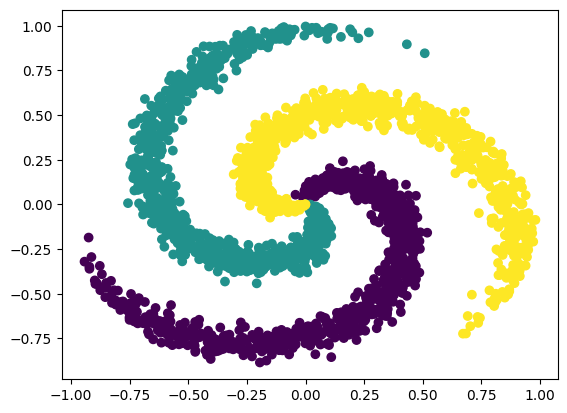

In [6]:
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [4]:
from lib.layers import Residual, Unpack
from lib.quantumsearch import FitnessFunction, OneToManyNetwork, QuantumSearch
from lib.quantumsearch import TransitionFunction

D = 2
H = 5
O = 3

encoder = nn.Sequential(
    nn.Linear(D, H),
    nn.ReLU(),
)

search = QuantumSearch(
    transition=TransitionFunction(
        OneToManyNetwork(
            nn.Sequential(
                nn.Linear(H, H),
                nn.ReLU(),
                nn.Linear(H, 3*H),
                Unpack(3) # Batch, ...,  3 * H -> Batch, ..., H, 3
            )
        ),
    ),
    fitness=FitnessFunction(
        OneToManyNetwork(
            nn.Sequential(
                nn.Linear(H, H),
                nn.ReLU(),
                nn.Linear(H, 3),
                Unpack(3) # Batch, ...,  3 * H -> Batch, ..., 1, 3
            )
        ),
    ),
    max_depth=3,
    beam_width=3,
    branching_width=3
)

decoder = nn.Sequential(
    nn.Linear(H, 3)
)

model = nn.Sequential(
    encoder,
    Residual(search),
    decoder
)

model.to(device)

Sequential(
  (0): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): ReLU()
  )
  (1): Residual(
    (module): QuantumSearch(
      (transition): TransitionFunction(
        (one_to_many): OneToManyNetwork(
          (network): Sequential(
            (0): Linear(in_features=5, out_features=5, bias=True)
            (1): ReLU()
            (2): Linear(in_features=5, out_features=15, bias=True)
            (3): Unpack()
          )
        )
      )
      (fitness): FitnessFunction(
        (one_to_many): OneToManyNetwork(
          (network): Sequential(
            (0): Linear(in_features=5, out_features=5, bias=True)
            (1): ReLU()
            (2): Linear(in_features=5, out_features=3, bias=True)
            (3): Unpack()
          )
        )
      )
    )
  )
  (2): Sequential(
    (0): Linear(in_features=5, out_features=3, bias=True)
  )
)

In [5]:
learning_rate = 1e-3
lambda_l2 = 1e-5

In [6]:

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
criterion = torch.nn.CrossEntropyLoss()

# we use the optim package to apply
# ADAM for our parameter updates
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# e = 1.  # plotting purpose
from torch.utils.data import TensorDataset, DataLoader

temperature = 3.0
gamma = 0.99

with device:
    dataset = TensorDataset(X, y)
    data_loader = DataLoader(dataset, 100, shuffle=True, generator=torch.Generator(device))

    # Training
    for t in range(100):

        for batch, targets in data_loader:

            # Feed forward to get the logits
            y_pred = model(batch)

            # loss
            loss = criterion(y_pred, targets)

            # accuracy
            score, predicted = torch.max(y_pred, 1)
            acc = (targets == predicted).sum().float() / len(targets)

            print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), acc))
            # display.clear_output(wait=False)

            # zero the gradients before running
            # the backward pass.
            optimizer.zero_grad()

            # Backward pass to compute the gradient
            # of loss w.r.t our learnable params.
            loss.backward()

            # clip gradient
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1e-2)

            # Update params
            optimizer.step()

[EPOCH]: 0, [LOSS]: 1.183748, [ACCURACY]: 0.370
[EPOCH]: 0, [LOSS]: 1.182662, [ACCURACY]: 0.330
[EPOCH]: 0, [LOSS]: 1.100600, [ACCURACY]: 0.470
[EPOCH]: 0, [LOSS]: 1.197207, [ACCURACY]: 0.290
[EPOCH]: 0, [LOSS]: 1.144759, [ACCURACY]: 0.470
[EPOCH]: 0, [LOSS]: 1.109948, [ACCURACY]: 0.440
[EPOCH]: 0, [LOSS]: 1.126823, [ACCURACY]: 0.390
[EPOCH]: 0, [LOSS]: 1.151899, [ACCURACY]: 0.300
[EPOCH]: 0, [LOSS]: 1.117403, [ACCURACY]: 0.330
[EPOCH]: 0, [LOSS]: 1.124102, [ACCURACY]: 0.300
[EPOCH]: 0, [LOSS]: 1.116978, [ACCURACY]: 0.320
[EPOCH]: 0, [LOSS]: 1.093844, [ACCURACY]: 0.430
[EPOCH]: 0, [LOSS]: 1.159845, [ACCURACY]: 0.390
[EPOCH]: 0, [LOSS]: 1.151052, [ACCURACY]: 0.340
[EPOCH]: 0, [LOSS]: 1.123063, [ACCURACY]: 0.380
[EPOCH]: 0, [LOSS]: 1.137540, [ACCURACY]: 0.340
[EPOCH]: 0, [LOSS]: 1.123445, [ACCURACY]: 0.340
[EPOCH]: 0, [LOSS]: 1.111768, [ACCURACY]: 0.320
[EPOCH]: 0, [LOSS]: 1.135972, [ACCURACY]: 0.360
[EPOCH]: 0, [LOSS]: 1.129288, [ACCURACY]: 0.340
[EPOCH]: 0, [LOSS]: 1.142841, [ACCURACY]